Let $d \in \mathbb{N}$.  Newman(1964) polinomial is

$$
N(x) = \prod_{i=1}^{d-1} ( x - a_n^i ) \quad \quad \quad a_n = \exp \left\{ - \frac{1}{\sqrt{d}} \right\}
$$

We use it to construct a rational function $r_n$ that uniformly approximates $|x|$ inside $[-1,1]$:

$$
r_n(x) = x \, \frac{N(x) - N(-x)}{N(x) + N(-x)} = \frac{p(x)}{q(x)}
$$

Both the numerator and the denominator have degree $d$. We have


$$
\sup_{x \in [-1,1]} \; \big| |x| - r_n(x) \big| \; \leq 3 e^{-\sqrt{d}}
$$

In [5]:
using Pkg
using LinearAlgebra
using Symbolics
using MultivariatePolynomials
using DynamicPolynomials
using HomotopyContinuation             
using Distributions
using Random
using Plots  
using PrettyTables

# Função que arredonda polinômios

function roundp(p)
      if p isa AbstractPolynomialLike
          cs = coefficients(p)
          ms = monomials(p)
          return isempty(cs) ? zero(p) : sum(round(c; digits=1) * m for (c, m) in zip(cs, ms))
      elseif p isa Number
          return round(p; digits=2)
      elseif p isa AbstractArray
          return map(roundp, p)
      else
          error("Unsupported type in roundp: $(typeof(p))")
      end
  end
  # -----

function expand_vector(v) 
    return [ModelKit.expand(v[i]) for i in 1:length(v)] end   

expand_vector (generic function with 1 method)

# Visualization

In [6]:

function f(x)
 return abs(x)
end  

function N(x,d) 
  a = exp( - 1 / sqrt(d) ) 
 return prod(   [ x + a^k  for k in 1:d-1   ]  )   
end

function r(x,d)
  return  x *(   N(x,d) - N(-x,d)   )/(  N(x,d) + N(-x,d)  )
end  



r (generic function with 1 method)

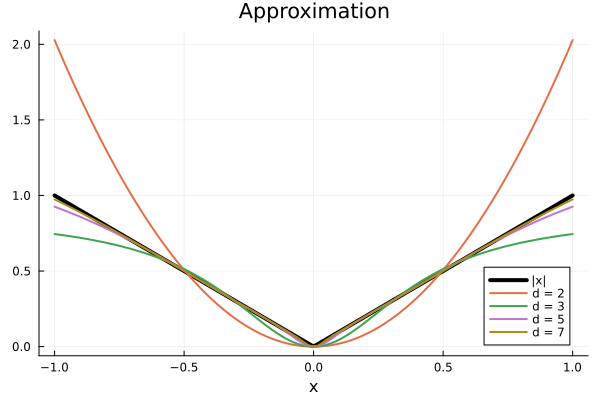

In [7]:
xs = range(-1, 1; length=200)
plot(xs, f.(xs); label="|x|", xlabel="x", title="Approximation" , lw=4, color=:black)

for d in [2,3,5,7]
 plot!(xs, r.(xs , d); label="d = $d", lw=2)
end 

display(current()) ; 

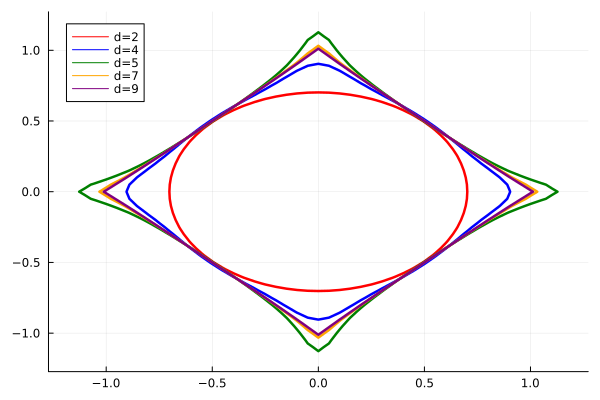

In [8]:
function R(x,d)
    return  sum( [    r(x[i],d)     for i in 1:2    ] ) 
end 

Z = Dict()

x_grid = [  i for i in -1.2: 0.05 :1.2 ]
y_grid = [  i for i in -1.2: 0.05 :1.2 ]    

colors = [:red, :blue, :green, :orange, :purple , :pink , :brown]  # lista de cores

plot()
for (i,d) in enumerate([2 , 4 , 5 , 7 , 9])
    Z[d] = [R([xi, yi], d) for yi in y_grid, xi in x_grid]
    contour!(x_grid, y_grid, Z[d], levels=[1], linewidth=2.5, linecolor=colors[i],colorbar = false )
    plot!([NaN], [NaN], color=colors[i], label="d=$d")  # adiciona entrada na legenda
end


display(current()) ; 

# LASSO

We are using a polinomial functio to approximate the $l^1$ norm and solve

$$
\min_{\beta} \; Q( \beta    ) \quad \quad s.t.  \quad \sum_{i=1}^k \frac{p(\beta_i)}{q( \beta_i)} \leq 1
$$

Where 

$$
p(\beta_i) = \beta_i N ( \beta_i) -  \beta_i N ( -\beta_i) \quad \quad q(\beta_i) = N ( \beta_i) +  N ( -\beta_i)
$$
  
   The Lagrangean is

$$
\mathcal{L}
=
Q(\beta)
+
\lambda \left[ \sum_{i=1}^k \frac{p(\beta_i)}{q( \beta_i)}  - 1  \right] = 0 
$$

Differentiating wrt to $\beta_i$ 

$$
-\boldsymbol{X}'( y - \boldsymbol{X} \beta)
+
\lambda 
\sum_{i=1}^k q(\beta_i)^{-1} \nabla p( \beta_i) - q(\beta_i)^{-2} \nabla q(\beta_i) = 0
$$

To turn this into a polinomial system, we must multiply it by $ Q_1( \beta) = \prod_{j=1}^k q(\beta_j)^2$. The system with the KT conditions is

$$
\begin{split}
& Q_2( \beta)  \big\{ \boldsymbol{X}'( y - \boldsymbol{X} \beta)
+
\lambda \nabla R( \beta) \big\} = 0  \\

& Q_1( \beta)(R( \beta)  + s^2 - 1) = 0 \\

& \lambda s = 0

\end{split}
$$

Where $Q_1( \beta) = \prod_{j=1}^k q(\beta_j)$


In [9]:
d = 8
a = exp( - 1 / sqrt(d) ) 
k = 2
n = 1000

using Random

Random.seed!(126)

X = rand(n, k)
beta_0 = [ 2, 0.1 ]


y = X* beta_0 + rand(Normal(0,1), n) ; 

@var β[1:k] λ s

function N(b) 
 return prod(   [ b + a^k  for k in 1:d-1   ]  )   
end

function p_num(x)
    return x * ( N(x) - N(-x)) 
end 

function q_num(x)
    return  N(x) + N(-x)
end 

function Q(b)
    return  (y - X*b)'*(y - X*b)
end 


p = [  p_num(β[i])   for i in 1:k  ]  
q = [  q_num(β[i])   for i in 1:k  ]  

pQ = [    prod([ q[j] for j in 1:k if j ≠ i  ])   for i in 1:k  ]


Dp = [    differentiate( p[i] , β[i]  )  for i in 1:k  ]
Dq = [    differentiate( q[i] , β[i]  )  for i in 1:k  ]
DQ = [    differentiate( Q(β) , β[i]  )  for i in 1:k  ]

2-element Vector{Expression}:
                                   -0.0519616785869743*(-2.46569023473273 - (0.0259808392934872*β₁ + 0.886184530400883*β₂)) - 0.995333054130557*(-2.22967099606934 - (0.497666527065279*β₁ + 0.2604260679959*β₂)) - 0.066170158711615*(-2.1677669718593 - (0.0330850793558075*β₁ + 0.0178318492043625*β₂)) - 0.0529981832537869*(-2.09787790390767 - (0.0264990916268935*β₁ + 0.111623626780902*β₂)) - 0.455882147176314*(-1.75984231698369 - (0.227941073588157*β₁ + 0.674268022282587*β₂)) - 0.144150472930827*(-1.73988368297946 - (0.0720752364654134*β₁ + 0.394009653177334*β₂)) - 0.394795723205619*(-1.70348569232159 - (0.197397861602809*β₁ + 0.853684898595136*β₂)) - 0.681222330800576*(-1.69331410003615 - (0.340611165400288*β₁ + 0.793532000009892*β₂)) - 1.06764884768338*(-1.69124432115458 - (0.533824423841689*β₁ + 0.66749696378094*β₂)) - 0.301680412663922*(-1.54504442702397 - (0.150840206331961*β₁ + 0.433570212345541*β₂)) - 0.400850586867334*(-1.53179641168257 - (0.2004252934

In [ ]:
# first part: s = 0      . é possível verificar que isso será a condição verdadeira vendo que o beta_ols está fora do conjunto restrição

eqA = expand_vector(    [   q[i]^2*DQ[i] + λ*( q[i]* Dp[i] - p[i]*Dq[i]  )  for i in 1:k ]  ) 
eqB = expand_vector(  sum( [  p[i]*pQ[i]  for i in 1:k ] ) - prod( q )    )

F = vec( [eqA ; eqB ] ) 

vars = [ β ; λ  ]

F_sys = System(F; variables=vars)

result = solve(F_sys ; start_system = :total_degree)

complex_sols_1 = solutions(result)

tol = 10^(-5)
# display( count(u -> all(abs.(imag.(u)) .< tol ), complex_sols_1) ) = 6

S_1 = [ real(s) for s in complex_sols_1 if all(abs.(imag.(s)) .< tol)] ; 

In [11]:
S_2 = []
S = [S_1; S_2]


# verificar se todas satisfazem a restrição

function R(b)
  return  sum( [    p_num(b[i]) /q_num(b[i])     for i in 1:k    ] ) 
end 

S = [  s[1:2] for s in S if R(s) -1 <= tol ]



OLS = inv(X' *X ) * X' * y
LASSO = S[  argmin([Q([x[1], x[2]]) for x in S])  ]


2-element Vector{Float64}:
 0.9804274588941155
 0.012249354386006025

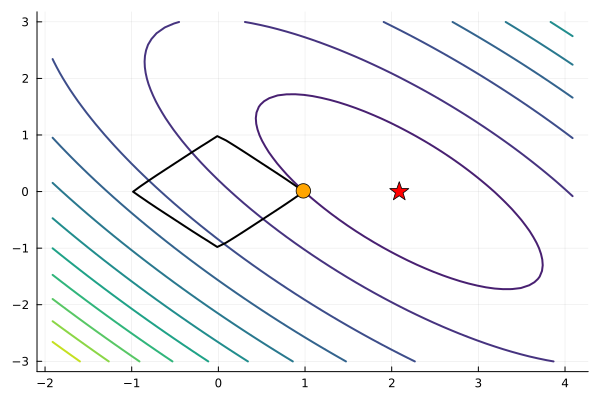

In [12]:
x_grid = [ OLS[1] + i for i in -4: 0.1 :2 ]
y_grid = [ OLS[2] + i for i in -3: 0.1 :3 ]    

Z = [Q([xi, yi]) for yi in y_grid, xi in x_grid]
Z2 = [R([xi, yi]) for yi in y_grid, xi in x_grid]

L = range(minimum(Z), maximum(Z), length=12) 
L = sort(vcat(collect(L), [Q(  [ LASSO[1], LASSO[2]  ] )])) 

contour(x_grid, y_grid, Z, levels= L, colormap = :viridis, linewidth=2)

# ponto a destacar
contour!(x_grid, y_grid, Z2, levels=[1], color=:black, linewidth=2, colorbar = false)

scatter!([LASSO[1]], [LASSO[2]], color=:orange, markersize=8, label="")
scatter!([OLS[1]], [OLS[2]], color=:red, markersize=10, label="" , marker =:star5)


# Performance

In [43]:
println( [ d=3 , "k = $2"   ])

Base.Meta.ParseError: ParseError:
# Error @ d:\Users\b435088\Desktop\Códigos Yuri\Aprox. LASSO.ipynb:1:24
println( [ d=3 , "k = $2"   ])
#                      └ ── identifier or parenthesized expression expected after $ in string

In [64]:
d_vals = 4:8
k_vals = 2:3

T = Array{Float64}(undef, length(d_vals), length(k_vals))   # matriz D×K



for d in d_vals, k in k_vals

    println( [ "d = $d" , "k = $k"   ])
    
    a = exp( - 1 / sqrt(d) ) 
     
    function N(b) 
        return prod(   [ b + a^k  for k in 1:d-1   ]  )   
    end
       
    function p_num(x)
        return x * ( N(x) - N(-x)) 
    end 
    
    function q_num(x)
        return  N(x) + N(-x)
    end     

    Random.seed!(126)

    X = rand(n, k)
    beta_0 = [i for i in 0.1:1:k-1 + 0.1]
    
    
    y = X* beta_0 + rand(Normal(0,1), n) ; 

    @var β[1:k] λ s

    function p_num(x)
        return x * ( N(x) - N(-x)) 
    end 
    
    function q_num(x)
        return  N(x) + N(-x)
    end 
    
    function Q(b)
        return  (y - X*b)'*(y - X*b)
    end 
    
    
    p = [  p_num(β[i])   for i in 1:k  ]  
    q = [  q_num(β[i])   for i in 1:k  ]  
    
    pQ = [    prod([ q[j] for j in 1:k if j ≠ i  ])   for i in 1:k  ]
    
    
    Dp = [    differentiate( p[i] , β[i]  )  for i in 1:k  ]
    Dq = [    differentiate( q[i] , β[i]  )  for i in 1:k  ]
    DQ = [    differentiate( Q(β) , β[i]  )  for i in 1:k  ]
    
    eqA = expand_vector(    [   q[i]^2*DQ[i] + λ*( q[i]* Dp[i] - p[i]*Dq[i]  )  for i in 1:k ]  ) 
    eqB = expand_vector(  sum( [  p[i]*pQ[i]  for i in 1:k ] ) - prod( q )    )
    
    F = vec( [eqA ; eqB ] ) 
    
    F_sys = System(F; variables=[ β ; λ  ])

    time = @elapsed result = solve(F_sys; start_system=:total_degree ,show_progress=false) 

    if count(u -> all(abs.(imag.(u)) .< tol ), complex_sols_1)  ≠ 0 println("Success")  end

    line = findfirst(==(d), d_vals)
    column = findfirst(==(k), k_vals)

    T[line,column] = time     # T[d,k]

end    

["d = 3", "k = 2"]
Sucess
["d = 3", "k = 3"]
Sucess
["d = 4", "k = 2"]
Sucess
["d = 4", "k = 3"]
Sucess
["d = 5", "k = 2"]
Sucess
["d = 5", "k = 3"]
Sucess
["d = 6", "k = 2"]
Sucess
["d = 6", "k = 3"]
Sucess
["d = 7", "k = 2"]
Sucess
["d = 7", "k = 3"]
Sucess
["d = 8", "k = 2"]
Sucess
["d = 8", "k = 3"]
Sucess


In [66]:
Head = ["d"; string.("k=", k_vals)]
data = hcat(d_vals, T)

pretty_table(data, header=Head)

┌─────┬───────────┬──────────┐
│   d │       k=2 │      k=3 │
├─────┼───────────┼──────────┤
│ 3.0 │ 0.0355994 │ 0.559944 │
│ 4.0 │  0.124798 │  1.87577 │
│ 5.0 │  0.547777 │  13.4401 │
│ 6.0 │   4.11135 │  28.2997 │
│ 7.0 │   5.77066 │  128.904 │
│ 8.0 │   7.75692 │  383.066 │
└─────┴───────────┴──────────┘
